# Exercise 20:

- Speed up by allowing forward/ backward steps to process a batch of X's and y's together.
- Plot results as a colormap.
- Split into train & validation properly.
- Use TQDM in python to show training process.
- Plot training & validation loss per epoch.

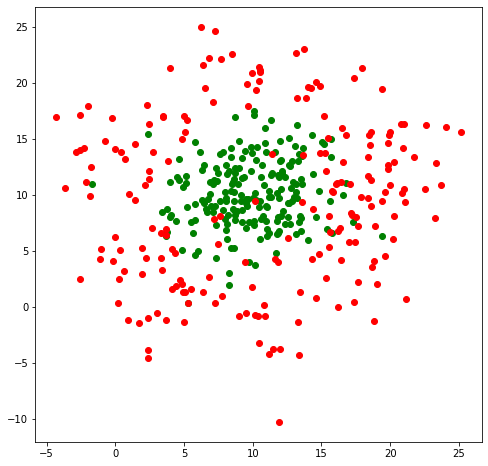

In [386]:
import numpy as np
import cvxopt
import matplotlib.pyplot as plt

# Gaussian center of the annulus

m_per_class = 200

mu = np.array([10, 10])
sigma = np.array([[10, 0], [0, 10]])
X1 = np.random.multivariate_normal(mu, sigma, m_per_class)

# Outer ring of annulus

r = 10
sigma = 3
theta = np.random.uniform(0, 2 * np.pi, m_per_class)
r = r + np.random.normal(0, sigma, m_per_class)
x, y = 10 + np.cos(theta) * r, 10 + np.sin(theta) * r
X2 = np.concatenate((x.reshape(-1, 1), y.reshape(-1, 1)), 1)
plt.figure(figsize=(8,8))
plt.plot(X1[:,0], X1[:,1], 'go')
plt.plot(X2[:,0], X2[:,1], 'ro')
plt.show()

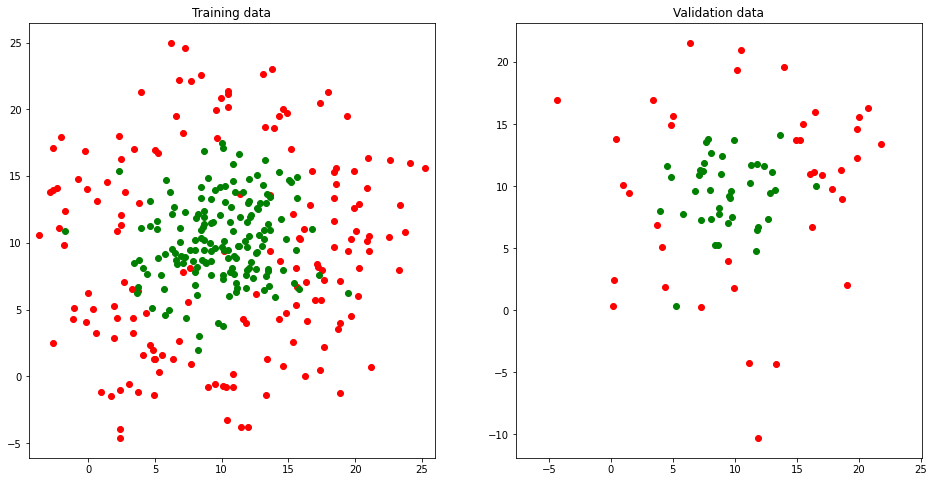

In [387]:

X = np.concatenate((X1, X2), 0)
y = np.concatenate((np.ones((X1.shape[0], 1)), np.zeros((X2.shape[0], 1))), 0)

def train_val_split(X,y,test_size):
    m=X.shape[0]
    idx=np.arange(m)
    np.random.shuffle(idx)
    m_train=int ((1-test_size)*m)
    train_idx = idx [:m_train]
    val_idx = idx [m_train:]
    X_train = X [train_idx,:]
    X_val = X [val_idx,:]
    y_train = y [train_idx,:]
    y_val = y [val_idx,:]
    return X_train,X_val,y_train,y_val

X_train,X_val,y_train,y_val=train_val_split(X,y,0.2)
def plot_data(X, y, title):
    X_0 = X[(y==0).flat]
    X_1 = X[(y==1).flat]
    plt.plot(X_0[:,0], X_0[:,1], 'ro')
    plt.plot(X_1[:,0], X_1[:,1], 'go')
    plt.title(title)
    plt.axis('equal')
    
plt.rcParams["figure.figsize"] = (16, 8)
plt.subplot(1,2, 1)
plot_data(X_train, y_train, 'Training data')
plt.subplot(1,2, 2)
plot_data(X_val, y_val, 'Validation data')

In [388]:
digits=2 #number of classes

Y_train=np.eye(digits)[y_train.reshape(-1).astype('int32')]
Y_val=np.eye(digits)[y_val.reshape(-1).astype('int32')]
X_train,Y_train,X_test,Y_test=X_train.T,Y_train.T,X_val.T,Y_val.T

In [389]:


def sigmoid(z):
    s = 1. / (1. + np.exp(-z))
    return s

def sigmoid_der(z):
    a = sigmoid(z)
    return a * (1 - a)

def relu(z):
    return np.where(z > 0, z, 0)

def relu_der(z):
    return np.where(z > 0, 1, 0)


def compute_loss(Y, Y_hat):

    L_sum = np.sum(np.multiply(Y, np.log(Y_hat)))
    m = Y.shape[1]
    L = -(1./m) * L_sum

    return L

def feed_forward(X, W, b):
    L = len(W)
    a[0] = X
    for l in range(1, L+1):
        z[l] = W[l] @ a[l-1] + b[l]
        a[l] = g[l](z[l])
        if l==L:
            a[l]=np.exp(z[l]) / np.sum(np.exp(z[l]), axis=0)
    #return cache

def back_propagate(X, Y, W):
    L = len(W)
    dW = {}
    db = {}
    delta[L] = a[L] - Y
    for l in range(L, 0, -1):
        # Calculate gradient for weights
        dW[l] = (1/m_batch) * (delta[l] @ a[l-1].T)
        # Calculate gradient for biases
        db[l] = (1/m_batch) * np.sum(delta[l], axis = 1, keepdims=True)
        # Calculate previous layer's deltas
        if l > 1:
            delta[l-1]=np.multiply(np.dot(W[l].T,delta[l]),1-np.power(a[l-1],2))
            delta[l-1]= np.dot(W[l].T,delta[l]) * a[l-1] * (1-a[l-1])
            delta[l-1]= np.dot(W[l].T,delta[l]) * gprime[l-1](z[l-1])
    return dW, db



def update_weights(W, b, dW, db, alpha):
    L = len(W)
    for l in range(1, L+1):
        #W[l] = W[l] - alpha * dW[l]
        V_dW[l] = (beta * V_dW[l] + (1. - beta) * dW[l])
        W[l] = W[l] - alpha * V_dW[l]
        #b[l] = b[l] - alpha * db[l]
        V_db[l] = (beta * V_db[l] + (1. - beta) * db[l])
        b[l] = b[l] - alpha * V_db[l]

# hyperparameters
n_x = X_train.shape[0]
m = X_train.shape[1]
n_h1 = 16
n_h2 = 32

alpha = 0.01
beta = 0.9
batch_size = 32
batches = -(-m // batch_size)

# initialization
W={}
W[1] = np.random.normal(0, 0.1, (n_h1, n_x))
W[2] = np.random.normal(0, 0.1, (n_h2, n_h1))
W[3] = np.random.normal(0, 0.1, (digits, n_h2))

L = len(W)

b = {}
b[1] = np.zeros((n_h1, 1)) + 0.5
b[2] = np.zeros((n_h2, 1)) + 0.5
b[3] = np.zeros((digits, 1))



V_dW = {}
V_db = {}
for l in range(1, L+1):
    V_dW[l] = np.zeros(W[l].shape)
    V_db[l] = np.zeros(b[l].shape)

z = {}
a ={}
delta = {}

gprime = {}
gprime[1] = relu_der
gprime[2] = relu_der
gprime[3] = sigmoid_der

g = {}
g[1] = relu
g[2] = relu
g[3] = sigmoid

train_costs = []
test_costs = []

from tqdm import tqdm

# training

for i in range(1200):
    permutation = np.random.permutation(X_train.shape[1])
    X_train_shuffled = X_train[:, permutation]
    Y_train_shuffled = Y_train[:, permutation]

    for j in range(batches):

        begin = j * batch_size
        end = min(begin + batch_size, X_train.shape[1] - 1)
        X = X_train_shuffled[:, begin:end]
        Y = Y_train_shuffled[:, begin:end]
        m_batch = end - begin

        feed_forward(X, W , b)
        dW, db = back_propagate(X, Y, W)

        update_weights(W, b, dW, db, alpha)


    feed_forward(X_train, W , b)
    train_cost = compute_loss(Y_train, a[L])
    train_costs.append(train_cost)
    feed_forward(X_test, W , b)
    test_cost = compute_loss(Y_test, a[L])
    test_costs.append(test_cost)
    print("Epoch {}: training cost = {}, test cost = {}".format(i+1 ,train_cost, test_cost))

print("Done.")

Epoch 1: training cost = 0.7104567049975232, test cost = 0.7139048467735595
Epoch 2: training cost = 0.6925093344248988, test cost = 0.6947400074480982
Epoch 3: training cost = 0.6893401856286698, test cost = 0.6917506733686078
Epoch 4: training cost = 0.6862884647735698, test cost = 0.6893105381876645
Epoch 5: training cost = 0.6816023657894124, test cost = 0.6857955210714279
Epoch 6: training cost = 0.677756388141898, test cost = 0.6829032069938
Epoch 7: training cost = 0.6741292798777994, test cost = 0.6802630540198534
Epoch 8: training cost = 0.6704504426900838, test cost = 0.6775548512582361
Epoch 9: training cost = 0.6668587278176906, test cost = 0.6748093105864329
Epoch 10: training cost = 0.6635296925114673, test cost = 0.6723227482294951
Epoch 11: training cost = 0.6600640150556182, test cost = 0.6700192420461959
Epoch 12: training cost = 0.6567805131383576, test cost = 0.667976650274979
Epoch 13: training cost = 0.6531044384798101, test cost = 0.6654266425450024
Epoch 14: tra

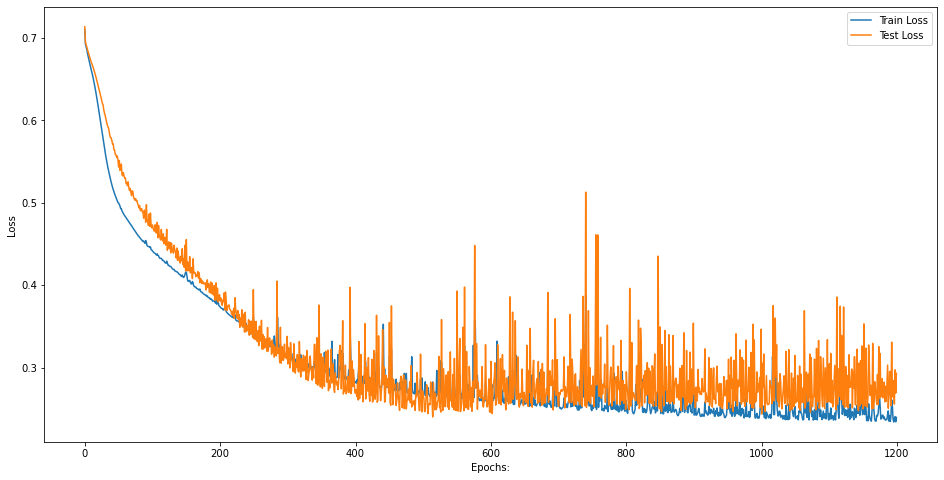

In [390]:
plt.plot(train_costs,label='Train Loss')
plt.plot(test_costs,label='Test Loss')
plt.ylabel('Loss')
plt.xlabel("Epochs:")
plt.legend()
plt.show()

In [391]:
def predict(X, W, b):
    feed_forward(X,  W, b)
    predictions = np.argmax(a[L], axis=0)
    return predictions
def accuracy(X,Y, W, b):
    feed_forward(X,  W, b)
    predictions = np.argmax(a[L], axis=0)
    labels = np.argmax(Y, axis=0)
    return (predictions==labels).mean()
print('Training accuracy: ', accuracy(X_train,Y_train, W, b))
print('Validation accuracy: ',accuracy(X_test,Y_test, W, b))

Training accuracy:  0.921875
Validation accuracy:  0.8875


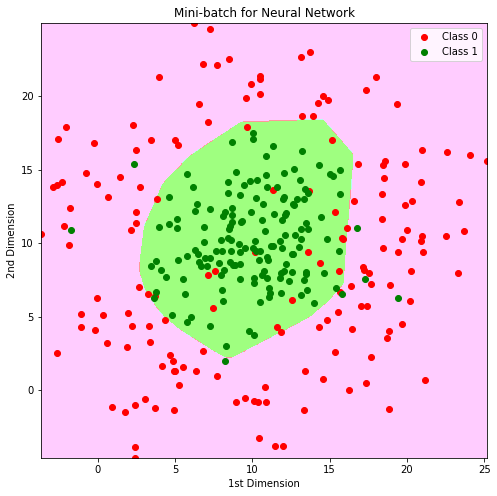

In [392]:
from matplotlib.colors import ListedColormap
custom_cmap =ListedColormap(['#ffccff','#b3fff0','#ff9999','#9fff80'])

x0, x1 = np.meshgrid(
    np.linspace(X_train.T[:, 0].min(), X_train.T[:, 0].max(), 500).reshape(-1, 1),
    np.linspace(X_train.T[:, 1].min(), X_train.T[:, 1].max(), 500).reshape(-1, 1)
)

X_new = np.c_[x0.ravel(), x1.ravel()]


y_pred = predict(X_new.T, W, b)
zz = y_pred.reshape(x0.shape)

plt.figure(figsize=(8,8))
plt.contourf(x0, x1, zz, cmap=custom_cmap)

plt.scatter(X_train.T[(y_train==0).flat][:,0], X_train.T[(y_train==0).flat][:,1], marker='o',color='red', label='Class 0')
plt.scatter(X_train.T[(y_train==1).flat][:,0], X_train.T[(y_train==1).flat][:,1], marker='o',color='green', label='Class 1')


plt.title('Mini-batch for Neural Network')
plt.xlabel('1st Dimension')
plt.ylabel('2nd Dimension')

plt.legend()
plt.show()